# Berkeley Earth process data

Process Berkeley Earth data - according to the findings in "BerkeleyEarth_data_availability".

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from utils import berkeley, utils

In [2]:
xr.set_options(display_style="text")

**NOTE**: as of 04.03.2024: only data until 2023-11-30 -> don't analyse 2023 (for now)

In [3]:
CLIMATOLOGY_PERIOD = slice("1961", "1990")

period = slice("1955", "2022")

## Compute and save Berkeley Earth TXx and TNn

### Load data

In [4]:
ds_tmax = berkeley.read("TMAX", time_period=period)
ds_tmax = ds_tmax.load()

In [5]:
ds_tmin = berkeley.read("TMIN", time_period=period)
ds_tmin = ds_tmin.load()

###  land mask

Clean the land mask

In [6]:
land_mask = berkeley.clean_landmask(ds_tmax)

### add the seasonal cycle

In [7]:
# add climatology, so the annual max can be properly determined
ds_tmax_seas = berkeley.add_climatology(ds_tmax)

ds_tmin_seas = berkeley.add_climatology(ds_tmin)

### calculate annual max/ min

In [8]:
with xr.set_options(use_flox=True):
    txx = ds_tmax_seas.groupby("time.year").max("time", engine="flox")

In [9]:
with xr.set_options(use_flox=True):
    tnn = ds_tmin_seas.groupby("time.year").min("time", engine="flox")

In [10]:
txx.name = "txx"
tnn.name = "tnn"

### calculate annual data availabiliy (fraction)

In [11]:
notnull_tmax_map = berkeley.annual_data_availability(ds_tmax.temperature)
notnull_tmin_map = berkeley.annual_data_availability(ds_tmin.temperature)

### 'require valid'

For each grid point
- require at least 99% data availability for each individual year
- require at least 90% data availability for the whole period

In [12]:
txx_99_90 = berkeley.require_valid(
    txx, notnull_tmax_map, valid_days=0.99, valid_years=0.9
)
tnn_99_90 = berkeley.require_valid(
    tnn, notnull_tmin_map, valid_days=0.99, valid_years=0.9
)

### calculate land mean

In [13]:
txx_99_90_land = utils.land_mean(txx_99_90, land_mask)
tnn_99_90_land = utils.land_mean(tnn_99_90, land_mask)

### calculate anomalies

In [14]:
txx_99_90_land = utils.calc_anomaly(txx_99_90_land, CLIMATOLOGY_PERIOD)
tnn_99_90_land = utils.calc_anomaly(tnn_99_90_land, CLIMATOLOGY_PERIOD)

### Save TXx and TNn

In [17]:
# NOTE: save it as *_1961_1990 because the climatology determines the offset
# i.e. if we update the climatology we have to update the offset (maybe we could
# save the slope instead below)

fN_out = berkeley.get_filename_post("txx", "99_90_land_1961_1990")
if not pathlib.Path(fN_out).exists():
    txx_99_90_land.to_dataset().to_netcdf(fN_out)

fN_out = berkeley.get_filename_post("tnn", "99_90_land_1961_1990")
if not pathlib.Path(fN_out).exists():
    tnn_99_90_land.to_dataset().to_netcdf(fN_out)

## Scaling & offset

Calculate scaling of txx/ tnn with global mean temperature to establish an offset for them. As the indices are only starting in 1955, but we want them relative to 1850-1900.



To obtain the offset we use a linear regression for our indices ($T^*$) and model

$T^* \sim T^{glob}$, i.e. $T^* = f(T^{glob}) =  b_0 + b_1 * T^{glob}$.

To obtain the offset we then calculate

$\Delta T^* = f(T^{glob}_{1961-1990}) - f(T^{glob}_{1850-1900}) = b_1 * T^{glob}_{1961-1990} - b_1 * T^{glob}_{1850-1900} = b_1 * \Delta T^{glob}$. 

In [18]:
berkeley_globmean_1850_1900 = berkeley.read_globmean(ref_period=slice(1850, 1900))

Calculate $\Delta Tglob$; the change in t glob between 1850-1900 and 1961-1990 (the second argument is 0 per definition)

In [19]:
delta_t_glob = berkeley_globmean_1850_1900.sel(year=CLIMATOLOGY_PERIOD).mean() - 0

Text(0, 0.5, 'T glob (°C)')

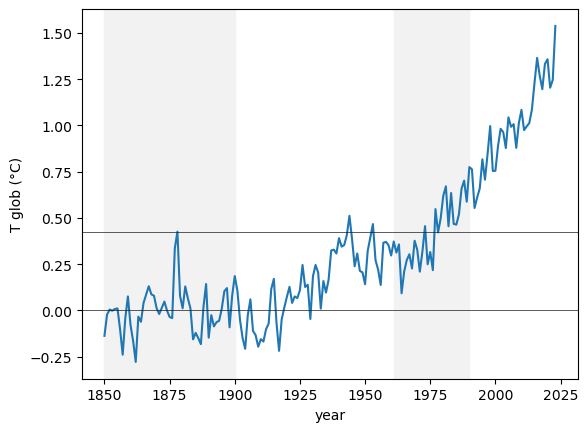

In [20]:
f, ax = plt.subplots()

berkeley_globmean_1850_1900.plot(ax=ax)

ax.axhline(0, color="0.1", lw=0.5)
ax.axhline(delta_t_glob, color="0.1", lw=0.5)

# ax.text(1850, delta_t_glob, "Warming 1850-1900 to 1961-1990", ha="left", va="bottom")

ax.axvspan(1850, 1900, color="0.95")

ax.axvspan(1961, 1990, color="0.95")

ax.set_ylabel("T glob (°C)")

In [21]:
def get_scaling(t_idx, t_glob, period, dim="year"):

    # cut the analysis period
    t_glob = t_glob.sel({dim: period})
    t_idx = t_idx.sel({dim: period})

    # add global mean temperatures as coords to index
    t_idx = t_idx.assign_coords(t_glob=t_glob)
    t_idx = t_idx.swap_dims({dim: "t_glob"})

    coeffs = t_idx.polyfit(dim="t_glob", deg=1)

    return t_idx, coeffs

In [22]:
txx_scaling, coeff_txx = get_scaling(
    t_idx=txx_99_90_land,
    t_glob=berkeley_globmean_1850_1900,
    period=slice(1955, 2020),
    dim="year",
)


tnn_scaling, coeff_tnn = get_scaling(
    t_idx=tnn_99_90_land,
    t_glob=berkeley_globmean_1850_1900,
    period=slice(1955, 2020),
    dim="year",
)

coeff_txx

<xarray.Dataset>
Dimensions:               (degree: 2)
Coordinates:
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree) float64 1.228 -0.5058

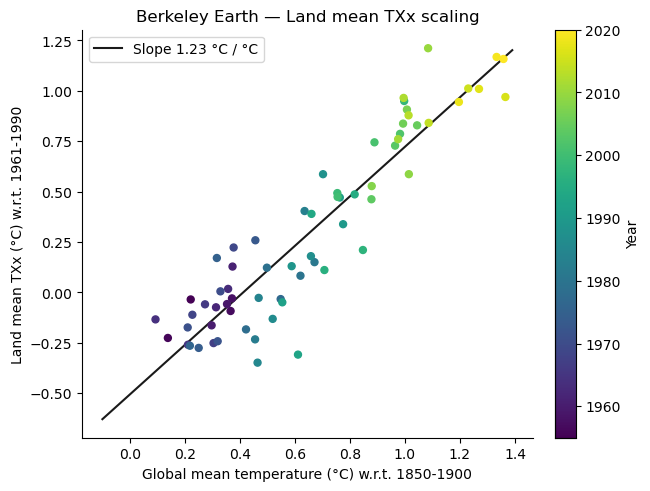

In [23]:
def plot_scaling(t_idx, coeff, variable, ax=None):

    # prepare data
    slope = coeff.polyfit_coefficients.sel(degree=1).item()

    x = np.arange(-0.1, 1.4, 0.01)
    x = xr.DataArray(x, dims="x", coords={"x": x})

    scaling = xr.polyval(x, coeff).polyfit_coefficients

    if ax is None:
        f, ax = plt.subplots(layout="constrained")

    # plot

    scaling.plot(
        ax=ax,
        color="0.1",
        label=f"Slope {slope:0.2f} °C / °C",
        zorder=1,
        lw=1.5,
    )

    h = ax.scatter(t_idx.t_glob, t_idx, c=t_idx.year, s=25)

    # ax.axhline(0, color="0.1", lw=0.5)
    # ax.axvline(0, color="0.1", lw=0.5)

    ax.set_xlabel("Global mean temperature (°C) w.r.t. 1850-1900")
    ax.set_ylabel(f"Land mean {variable} (°C) w.r.t. 1961-1990")

    ax.set_title(f"Berkeley Earth — Land mean {variable} scaling")

    ax.legend()

    cbar = plt.colorbar(h, ax=ax)

    cbar.set_label("Year")

    sns.despine(ax.figure)


plot_scaling(txx_scaling, coeff_txx, variable="TXx")

plt.savefig(utils.fig_dir / "BerkeleyEarth_land_mean_txx_scaling.png", dpi=300)
plt.savefig(utils.fig_dir / "BerkeleyEarth_land_mean_txx_scaling.pdf", dpi=300)

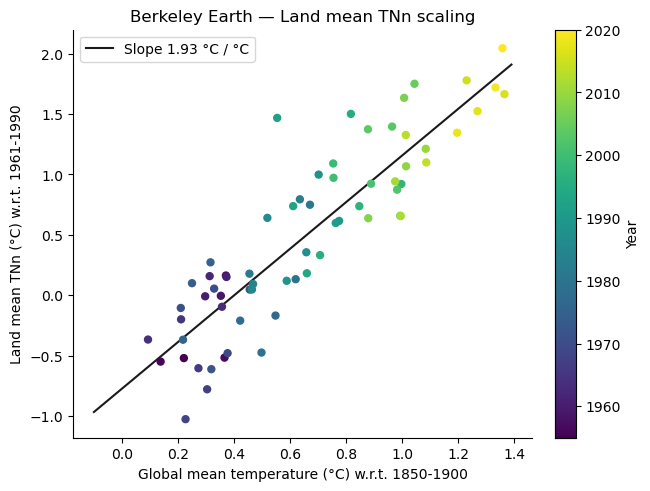

In [24]:
plot_scaling(tnn_scaling, coeff_tnn, variable="TNn")

In [25]:
txx_offset_1961_1990 = (
    coeff_txx.polyfit_coefficients.sel(degree=1, drop=True) * delta_t_glob
)

txx_offset_1961_1990.name = "offset"


txx_offset_1961_1990.attrs = {
    "info": "TXx offset between 1850-1900 and 1961-1900",
    "method": (
        "based on the linear relationship for Berkeley Earth Tglob "
        "and TXx for 1955 and 2020."
    ),
}


fN_out = berkeley.get_filename_post("txx", "offset_99_90_land_1961_1990")
if not pathlib.Path(fN_out).exists():
    txx_offset_1961_1990.to_dataset().to_netcdf(fN_out)


txx_offset_1961_1990

<xarray.DataArray 'offset' ()>
array(0.51798067)
Attributes:
    info:     TXx offset between 1850-1900 and 1961-1900
    method:   based on the linear relationship for Berkeley Earth Tglob and T...

In [26]:
tnn_offset_1961_1990 = (
    coeff_tnn.polyfit_coefficients.sel(degree=1, drop=True) * delta_t_glob
)

tnn_offset_1961_1990.name = "offset"


tnn_offset_1961_1990.attrs = {
    "info": "TNn offset between 1850-1900 and 1961-1900",
    "method": (
        "based on the linear relationship for Berkeley Earth Tglob "
        "and TNn for 1955 and 2020."
    ),
}


fN_out = berkeley.get_filename_post("tnn", "offset_99_90_land_1961_1990")
if not pathlib.Path(fN_out).exists():
    tnn_offset_1961_1990.to_dataset().to_netcdf(fN_out)


print(tnn_offset_1961_1990)

<xarray.DataArray 'offset' ()>
array(0.81414786)
Attributes:
    info:     TNn offset between 1850-1900 and 1961-1900
    method:   based on the linear relationship for Berkeley Earth Tglob and T...


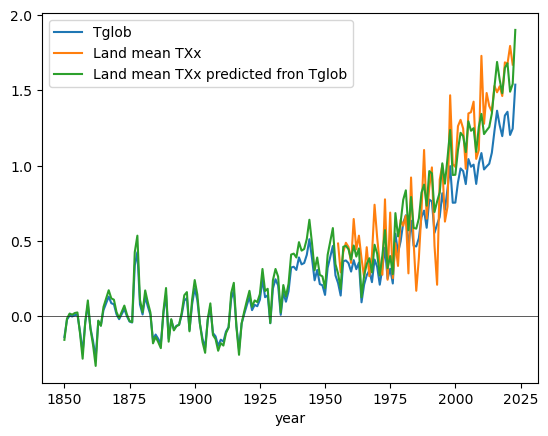

In [27]:
def predicted_ind(t_ind, t_glob, coeff, offset, variable):

    pred = xr.polyval(t_glob, coeff).polyfit_coefficients

    f, ax = plt.subplots()

    t_glob.plot(label="Tglob")

    (t_ind + offset).plot(label=f"Land mean {variable}")

    (pred + offset).plot(label=f"Land mean {variable} predicted fron Tglob")

    ax.axhline(0, color="0.1", lw=0.5)

    plt.legend()


predicted_ind(
    txx_99_90_land, berkeley_globmean_1850_1900, coeff_txx, txx_offset_1961_1990, "TXx"
)

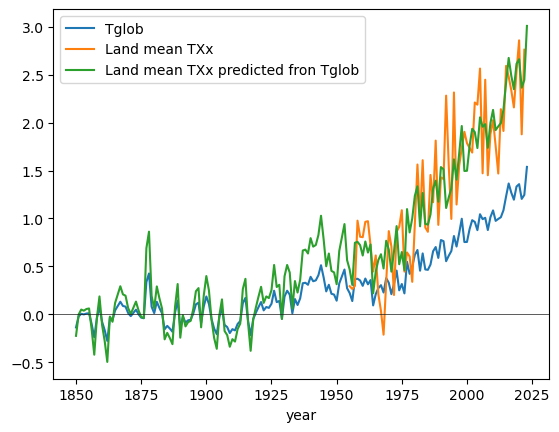

In [28]:
predicted_ind(
    tnn_99_90_land, berkeley_globmean_1850_1900, coeff_tnn, tnn_offset_1961_1990, "TXx"
)